In [1]:
"""
1. preprocessing data

2. tools
2.1 generates position embedding
2.2 create mask (padding, decoder)
2.3 scaled_dot_product_attention

3.build model
3.1 multiheadAttention
3.2 EncoderLayer
3.3 DecoderLayer
3.4 EncoderModel
3.5 DecoderModel
3.6 Transformer

4 train
4.1 initialize model
4.2 define loss optimizer, learning_rate schedule
4.3 train_step
4.4 train process

6 evalution
7 visualize results(attention)
"""

'\n1. preprocessing data\n\n2. tools\n2.1 generates position embedding\n2.2 create mask (padding, decoder)\n2.3 scaled_dot_product_attention\n\n3.build model\n3.1 multiheadAttention\n3.2 EncoderLayer\n3.3 DecoderLayer\n3.4 EncoderModel\n3.5 DecoderModel\n3.6 Transformer\n\n4 train\n4.1 initialize model\n4.2 define loss optimizer, learning_rate schedule\n4.3 train_step\n4.4 train process\n\n6 evalution\n7 visualize results(attention)\n'

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-beta1
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.16.2
pandas 0.25.3
sklearn 0.22
tensorflow 2.0.0-beta1
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1. preprocessing data

In [4]:
import tensorflow_datasets as tfds
examples, info = tfds.load("ted_hrlr_translate/pt_to_en",
                           with_info = True,
                          as_supervised = True)
train_examples, val_examples = examples["train"], examples["validation"]
print(info)

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=1.0.0,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.
',
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
      booktitle = {HLT-NAACL},
      year    = {2018},
      }""",
    redistribution_info=,
)



In [5]:
for pt, en in train_examples.take(5):
    print(pt.numpy())
    print(en.numpy())
    print()

b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'
b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'

b'mas e se estes fatores fossem ativos ?'
b'but what if it were active ?'

b'mas eles n\xc3\xa3o tinham a curiosidade de me testar .'
b"but they did n't test for curiosity ."

b'e esta rebeldia consciente \xc3\xa9 a raz\xc3\xa3o pela qual eu , como agn\xc3\xb3stica , posso ainda ter f\xc3\xa9 .'
b'and this conscious defiance is why i , as an agnostic , can still have faith .'

b"`` `` '' podem usar tudo sobre a mesa no meu corpo . ''"
b'you can use everything on the table on me .'



In [6]:
# 转成subword
en_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt , en in train_examples),
    target_vocab_size = 2 ** 13
)
pt_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt , en in train_examples),
    target_vocab_size = 2 ** 13
)

In [7]:
sample_string = "Transformer is awesome."
tokenized_string = en_tokenizer.encode(sample_string)
print("Tokenized string is {}".format(tokenized_string))

origin_string = en_tokenizer.decode(tokenized_string)
print("Origin string is {}".format(origin_string))

# "{} -> '{}'" 在内部加一层引号保留空格
for token in tokenized_string:
    print("{} -> '{}'".format(token, en_tokenizer.decode([token])))

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
Origin string is Transformer is awesome.
7915 -> 'T'
1248 -> 'ran'
7946 -> 's'
7194 -> 'former '
13 -> 'is '
2799 -> 'awesome'
7877 -> '.'


In [8]:
buffer_size = 20000
batch_size = 64
max_length = 40

# 利用tokenizer将string转成subword并加上起始终止标志符
def encode_to_subword(pt_sentence, en_sentence):
    # 加上前缀和后缀，相当于<start>
    pt_sequence = [pt_tokenizer.vocab_size] \
    + pt_tokenizer.encode(pt_sentence.numpy()) \
    + [pt_tokenizer.vocab_size+1]
    
    en_sequence = [en_tokenizer.vocab_size] \
    + en_tokenizer.encode(en_sentence.numpy()) \
    + [en_tokenizer.vocab_size+1]
    return pt_sequence, en_sequence

# 
def filter_by_max_length(pt, en):
    return tf.logical_and(tf.size(pt) <= max_length, 
                         tf.size(en) <= max_length)

# 封装python函数
def tf_encoder_to_subword(pt_sentence, en_sentence):
    return tf.py_function(encode_to_subword,
                         [pt_sentence, en_sentence],
                         [tf.int64, tf.int64])

train_dataset = train_examples.map(tf_encoder_to_subword)
train_dataset = train_dataset.filter(filter_by_max_length)
train_dataset = train_dataset.shuffle(batch_size).padded_batch(
    batch_size, padded_shapes=([-1], [-1])) # 在当前两个维度上都取最高的那个值

valid_dataset = val_examples.map(tf_encoder_to_subword)
valid_dataset = valid_dataset.filter(filter_by_max_length)
valid_dataset = valid_dataset.shuffle(batch_size).padded_batch(
    batch_size, padded_shapes=([-1], [-1])) # 在当前两个维度上都取最高的那个值

In [9]:
for pt_batch, en_batch in valid_dataset.take(5):
    print(pt_batch.shape, en_batch.shape)

(64, 39) (64, 31)
(64, 38) (64, 40)
(64, 39) (64, 39)
(64, 38) (64, 36)
(64, 40) (64, 35)


### 2.tools

#### 2.1 generates position embedding

In [10]:
# PE (pos,2i) = sin(pos / 10000 ^ (2i/d_model))
# PE (pos,2i+1) = cos(pos / 10000 ^ (2i/d_model))
# pos [sentence_length, 1]
# i.shape : [1,d_model] 
# result : [sentence_length, d_model]  
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, 2 *(i//2)/np.float32(d_model))
    return pos * angle_rates

def get_position_embedding(sentence_length, d_model):
    angle_rads = get_angles(np.arange(sentence_length)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)
    # sines.shape : [sentence_length, d_model / 2]
    # cosenes.shape : [sentence_length, d_model / 2]
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    
    # position_embedding.shape: [sentence_length, d_model]
    position_embedding = np.concatenate([sines, cosines], axis = -1)
    
    # position_embedding.shape: [1,sentence_length, d_model]
    position_embedding = position_embedding[np.newaxis, ... ]
    
    return tf.cast(position_embedding, dtype=tf.float32)

position_embedding = get_position_embedding(50,512)
print(position_embedding.shape)
    


(1, 50, 512)


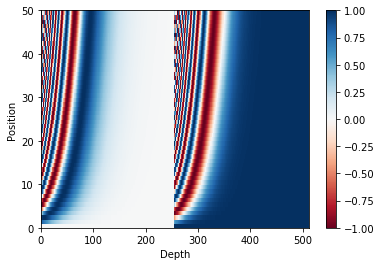

In [11]:
def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0], cmap = "RdBu")
    plt.xlabel("Depth")
    plt.xlim((0,512))
    plt.ylabel("Position")
    plt.colorbar()
    plt.show()
plot_position_embedding(position_embedding)

#### 2.2 mask(1.padding mask, 2.look ahead)

In [12]:
def create_padding_mask(batch_data):
    padding_mask = tf.cast(tf.math.equal(batch_data, 0), tf.float32)
    return padding_mask[:, tf.newaxis, tf.newaxis, :]

x = tf.constant([[7,6,0,0,1], [1,2,3,0,0], [0,0,0,4,5]])
create_padding_mask(x)
# 并没有取反， 0的时候取1

<tf.Tensor: id=313655, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [13]:
# 在decode中不让前词看到后词
# attention_weights:
#  [  [1,2,3],
#     [4,5,6],
#     [4,5,6] ]
# =>
#  [  [1,0,0],
#     [4,5,0],
#     [4,5,6] ]
# mask.shape : (seq_len, seq_len)
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask #(seq_len, seq_len)

create_look_ahead_mask(3)

<tf.Tensor: id=313664, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

#### 2.3 scaled_dot_product_attention 

In [14]:
def scaled_dot_product_attention(q,k,v,mask):
    """
    Args:
    - q: shape == (..., seq_len_q, depth)
    - k: shape == (..., seq_len_k, depth)
    - v: shape == (..., seq_len_v, depth_v)
    - seq_len_k == seq_len_v
    - mask: shape == (..., seq_len_q, seq_len_k)
    Returns:
    - output:weighted sum
    - attention_weights: weights of attention
    """
    # q和kT要作矩阵乘法， 所以最后一维depth相等
    # k和v是key value 对应 
    
    # shape: (..., seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q,k,transpose_b = True)
    
    # k 的最后一维depth
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # 为什么加一个很小的数
    #  softmax 一个很小的数会无限接近0，mask里为0的地方不会变
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    # 在seq_len_k维度上做softmax
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis = -1)
    
    # shape: (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

def print_scaled_dot_product_attention(q,k,v):
    temp_out, temp_att = scaled_dot_product_attention(q,k,v,None)
    print("Attention weights are :")
    print(temp_att)
    print("Output is : ")
    print(temp_out)
    
    

In [15]:
temp_q1 = tf.constant([[0,10,0]], dtype = tf.float32) # (1,3)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype = tf.float32) # (4,3)
temp_v = tf.constant([[1,0],
                      [10,0],
                      [100,5],
                      [1000,6]], dtype = tf.float32) # (4,2)
# 无限接近于0的数打印就是0
np.set_printoptions(suppress=True)
print_scaled_dot_product_attention(temp_q1,temp_k,temp_v)


Attention weights are :
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is : 
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [16]:
temp_q2 = tf.constant([[0,0,10]], dtype = tf.float32) # (1,3)、
print_scaled_dot_product_attention(temp_q2,temp_k,temp_v)

Attention weights are :
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is : 
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [17]:
temp_q3 = tf.constant([[10,10,0]], dtype = tf.float32) # (1,3)
print_scaled_dot_product_attention(temp_q3,temp_k,temp_v)

Attention weights are :
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is : 
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [18]:
temp_q4 =  tf.constant([[0,0,10],
                        [0,10,0],
                        [10,10,0]], 
                        dtype = tf.float32) # (1,3)
print_scaled_dot_product_attention(temp_q4,temp_k,temp_v)

Attention weights are :
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is : 
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


### 3.build model

#### 3.1 MultiHeadAttention

In [19]:
class MultiHeadAttention(keras.layers.Layer):
    """
    理论
    x -> Wq0 -> q0
    x -> Wk0 -> k0
    x -> Wv0 -> v0
    实际
    q -> Wq0 -> q0
    k -> Wk0 -> k0
    v -> Wv0 -> v0
    
    q -> Wq -> Q -> split -> q0,q1,q2...
    """
    
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert self.d_model % self.num_heads == 0
        self.depth =d_model // self.num_heads
        
        self.WQ = keras.layers.Dense(self.d_model)
        self.WK = keras.layers.Dense(self.d_model)        
        self.WV = keras.layers.Dense(self.d_model)
        
        self.dense = keras.layers.Dense(self.d_model)
        
    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]
        # 输入之前入果做self_attention shape: (batch_size, seq_len, word_embedding.dims)
        # 如果是中间的层次 shape：(batch_size, seq_len, 上一步输出的dim)
        q = self.WQ(q) # q.shape: (batch_size, seq_len_q, d_model)
        k = self.WK(k) # k.shape: (batch_size, seq_len_kv, d_model)
        v = self.WV(v) # v.shape: (batch_size, seq_len_kv, d_model)
        
        
        # q.shape: (batch_size, num_heads, seq_length_q, depth)
        q = self.split_heads(q, batch_size)
        # k.shape: (batch_size, num_heads, seq_length_kv, depth)
        k = self.split_heads(k, batch_size)
        # v.shape: (batch_size, num_heads, seq_length_kv, depth)
        v = self.split_heads(v, batch_size)
        
        # 为何要维度切换
        # 因为计算attention地时候用的是后两维去计算
        # 所以需要先把num_heads这一维先换到前面去
        
        
        # scaled_attention_outputs.shape : (batch_size, num_heads, seq_length_q, depth)
        # attention_weights.shape : (batch_size, num_heads, seq_length_q, seq_length_kv)
        scaled_attention_outputs, attention_weights = scaled_dot_product_attention(q,k,v,mask)
        
        # scaled_attention_outputs.shape : (batch_size, seq_length_q, num_heads, depth)
        scaled_attention_outputs = tf.transpose(
            scaled_attention_outputs, perm = [0,2,1,3]
        )
        
        # concat_attention.shape : (batch_size, seq_length_q, d_mode)
        concat_attention = tf.reshape(scaled_attention_outputs,
                                     (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        return output, attention_weights
        
    def split_heads(self, x, batch_size):
        # x.shape: (batch_size, seq_len, d_model)
        # d_model = num_heads * depth
        # x -> (batch_size, num_heads, seq_len, self.depth)
        
        x= tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # perm 维度交换
        return tf.transpose(x, perm=[0,2,1,3])
        
temp_mha = MultiHeadAttention(d_model = 512, num_heads = 8)
y = tf.random.uniform((1,60,256))
output, attn = temp_mha(y,y,y,mask = None)
print(output.shape)

print(attn.shape)

(1, 60, 512)
(1, 8, 60, 60)


#### 3.2 Encoder layer

In [20]:
def feed_forward_network(d_model, dff):
    # dff : dim of feed_forward_network
    return keras.Sequential([
        keras.layers.Dense(dff, activation="relu"),
        keras.layers.Dense(d_model)
        
    ])

sample_ffn = feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64,50,512))).shape

TensorShape([64, 50, 512])

In [21]:
class EncoderLayer(keras.layers.Layer):
    """
    x -> self_attention -> add & normalize & dropout
        -> feed_forward -> add & normalize & dropout
    """
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward_network(d_model, dff)
        
        self.layer_normal_1 = keras.layers.LayerNormalization(epsilon= 1e-6)
        self.layer_normal_2 = keras.layers.LayerNormalization(epsilon= 1e-6)
        
        self.dropout_1 = keras.layers.Dropout(rate)
        self.dropout_2 = keras.layers.Dropout(rate)
        

    def call(self, x, training, encoder_padding_mask):
        # x.shape           : (batch_size, seq_len, dim = d_model) 因为add操作
        # attn_output.shape : (batch_size, seq_len, d_model)
        attn_output, _ = self.mha(x,x,x,encoder_padding_mask)
        attn_output = self.dropout_1(attn_output, training = training)
        
        # out_1.shape       : (batch_size, seq_len, d_model)
        out_1 = self.layer_normal_1(x + attn_output)
        
        # ffn_output.shape: (batch_size, seq_len, d_model)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output, training = training)
        out_2 = self.layer_normal_2(out_1 + ffn_output)
        
        return out_2

sample_encoder_layer = EncoderLayer(512, 8, 2048)
# 产生均匀分布的随机张量
sample_input = tf.random.uniform((64, 50, 512))
sample_output = sample_encoder_layer(sample_input, False, None)
print(sample_output.shape)
        

(64, 50, 512)


#### 3.3 DecoderLayer

In [22]:
class DecoderLayer(keras.layers.Layer):
    """
    x -> self_attention -> add & normalize & dropout -> out_1
    out_1, encoding_outputs -> attention -> add & normalize & dropout -> out_2
    out_2  -> feed_forward -> add & normalize & dropout -> out_3
    """
    def __init__(self, d_model, num_heads, dff, rate = 0.1):
        super(DecoderLayer, self).__init__()
        # 给输入作attention
        self.mha_1 = MultiHeadAttention(d_model, num_heads)
        # 给encoder和decoder之间做attention
        self.mha_2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward_network(d_model, dff)
        
        self.layer_normal_1 = keras.layers.LayerNormalization(epsilon= 1e-6)
        self.layer_normal_2 = keras.layers.LayerNormalization(epsilon= 1e-6)
        self.layer_normal_3 = keras.layers.LayerNormalization(epsilon= 1e-6)
        
        self.dropout_1 = keras.layers.Dropout(rate)
        self.dropout_2 = keras.layers.Dropout(rate)
        self.dropout_3 = keras.layers.Dropout(rate)

    def call(self, x, encoding_outputs, training, 
             decoder_mask, encoder_decoder_padding_mask):
        # decoder_mask: 是由look_ahead_mask和decoder_padding_mask混合而来
        # x.shape                : (batch_size, target_seq_len, d_model)
        # encoding_outputs.shape : (batch_size, input_seq_len, d_model)
        
        # attn_1/out_1.shape     : (batch_size, target_seq_len, d_model)
        attn_1, attn_weights_1 = self.mha_1(x, x, x, decoder_mask)
        attn_1 = self.dropout_1(attn_1, training = training)
        out_1 = self.layer_normal_1(attn_1 + x)
        
        # attn_2/out_2.shape     : (batch_size, target_seq_len, d_model)
        attn_2, attn_weights_2 = self.mha_2(out_1, encoding_outputs, encoding_outputs, 
                                            encoder_decoder_padding_mask)
        attn_2 = self.dropout_2(attn_2, training = training)
        out_2 = self.layer_normal_1(attn_2 + out_1)
        
        # ffn_output/out_3.shape: (batch_size, target_seq_len, d_model)
        ffn_output = self.ffn(out_2)
        ffn_output = self.dropout_3(ffn_output, training = training)
        out_3 = self.layer_normal_3(out_2 + ffn_output)
        
        return out_3, attn_weights_1, attn_weights_2

sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_input = tf.random.uniform((64, 60, 512))
sample_decoder_output, sample_decoder_attn_weights_1, sample_decoder_attn_weights_2 = sample_decoder_layer(
    sample_decoder_input, sample_output, False, None, None)
print(sample_decoder_output.shape)
print(sample_decoder_attn_weights_1.shape)
print(sample_decoder_attn_weights_2.shape)

        

(64, 60, 512)
(64, 8, 60, 60)
(64, 8, 60, 50)


#### 3.4 EncoderModel
##### 区别于encoder layer  多了wordembedding,还有多层组合

In [23]:
class EncoderModel(keras.layers.Layer):
    def __init__(self, num_layers, input_vocab_size, max_length,
                d_model, num_heads, dff, rate=0.1):
        super(EncoderModel, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.max_length = max_length
        self.embedding = keras.layers.Embedding(input_vocab_size, self.d_model)

        self.dropout = keras.layers.Dropout(rate)
        
        # position_embedding.shape     : (1, max_length, d_model)
        self.position_embedding = get_position_embedding(max_length, self.d_model)
        self.encoder_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                               for _ in range(self.num_layers)]
    def call(self, x, training, encoder_padding_mask):
        # x.shape         : (batch_size, input_seq_len)
        input_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(input_seq_len, self.max_length,
                                      "input_seq_len should <= self.max_length")
        # assert input_seq_len <= self.max_length
        
        # x.shape    :(batch_size, input_seq_len, d_model)
        x = self.embedding(x)
        
        # embedding 初始化默认从0-1之间取到的，缩放使得x在0-d_model, 
        # 使x在加上posi_embed之后本身起的作用大一些
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        # 维度不对应，第一维1可以自动扩展batch_size份，第二维用切片
        x += self.position_embedding[:, :input_seq_len, :]
        
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
           x =self.encoder_layers[i](x, training, encoder_padding_mask)
        
        # x.shape: (batch_size, input_seq_len, d_model)
        return x
    
sample_encoder_model = EncoderModel(2, 8500, max_length, 512, 8, 2048)
sample_encoder_model_input = tf.random.uniform((64,37))
sample_encoder_model_output = sample_encoder_model(
    sample_encoder_model_input, 
    False, encoder_padding_mask = None)
print(sample_encoder_model_output.shape)

(64, 37, 512)


####  3.5 DecoderModel

In [24]:
class DecoderModel(keras.layers.Layer):
    def __init__(self, num_layers, target_vocab_size, max_length,
                d_model, num_heads, dff, rate=0.1):
        super(DecoderModel, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.max_length = max_length
        self.embedding = keras.layers.Embedding(target_vocab_size, d_model)
        
        # position_embedding.shape     : (1, max_length, d_model)
        self.position_embedding = get_position_embedding(max_length, d_model)
        self.dropout = keras.layers.Dropout(rate)
        
        self.decoder_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                               for _ in range(self.num_layers)]
    def call(self, x, encoding_outputs, training, 
             decoder_mask, encoder_decoder_padding_mask):
        # x.shape         : (batch_size, output_seq_len)
        output_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(output_seq_len, self.max_length,
                                      "output_seq_len should <= self.max_length")
        # assert output_seq_len <= self.max_length
        
        attention_weights = {}
        
        # x.shape    :(batch_size, output_seq_len, d_model)
        x = self.embedding(x)
        
        # embedding 初始化默认从0-1之间取到的，缩放使得x在0-d_model, 
        # 使x在加上posi_embed之后本身起的作用大一些
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        # 维度不对应，第一维1可以自动扩展batch_size份，第二维用切片
        x += self.position_embedding[:, :output_seq_len, :]
        
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            x, attn_1, attn_2 = self.decoder_layers[i](
                x, encoding_outputs, training, 
                decoder_mask, encoder_decoder_padding_mask)
            attention_weights[
                "decoder_layer{}_attn_1".format(i+1)] = attn_1
            attention_weights[
                "decoder_layer{}_attn_2".format(i+1)] = attn_2
        
        # x.shape: (batch_size, output_seq_len, d_model)
        return x, attention_weights
    
sample_decoder_model = DecoderModel(2, 8000, max_length, 512, 8, 2048)
sample_decoder_model_input = tf.random.uniform((64,35))
sample_decoder_model_output, sample_decoder_model_attr= sample_decoder_model(
    sample_decoder_model_input,
    sample_encoder_model_output,
    training = False,
    decoder_mask = None,
    encoder_decoder_padding_mask = None,
)
print(sample_decoder_model_output.shape)
print(sample_decoder_model_attr.keys())
for key in sample_decoder_model_attr:
    print(sample_decoder_model_attr[key].shape)

(64, 35, 512)
dict_keys(['decoder_layer1_attn_1', 'decoder_layer1_attn_2', 'decoder_layer2_attn_1', 'decoder_layer2_attn_2'])
(64, 8, 35, 35)
(64, 8, 35, 37)
(64, 8, 35, 35)
(64, 8, 35, 37)


#### 3.5 Transformer

In [25]:
# 子类api调用继承问提
# 仅最后一层大model继承keras.Model, 其他都继承自keras.layers.Layer
class Transformer(keras.Model):
    def __init__(self, num_layers, input_vocab_size, target_vocab_size,
                max_length, d_model, num_heads, dff, rate = 0.1):
        super(Transformer, self).__init__()
        
        self.encoder_model = EncoderModel(
            num_layers, input_vocab_size, max_length,
            d_model, num_heads, dff, rate
        )
        
        self.decoder_model = DecoderModel(
            num_layers, target_vocab_size, max_length,
            d_model, num_heads, dff, rate
        )
        self.final_layer = keras.layers.Dense(target_vocab_size)
    def call(self, inp, tar, training, encoder_padding_mask, 
            decoder_mask, encoder_decoder_padding_mask):
        # encoding_output.shape: (batch_size, input_seq_len, d_model)
        encoding_outputs = self.encoder_model(
            inp, training, encoder_padding_mask)
        # decoding_outputs.shap： (batch_size, output_seq_len, d_model)
        decoding_outputs, attention_weights = self.decoder_model(
            tar, encoding_outputs, training, decoder_mask, encoder_decoder_padding_mask)
        
        # prediction.shape: (batch_size, output_seq_len, target_vocab_size)
        predictions = self.final_layer(decoding_outputs)
        
        return predictions, attention_weights

sample_transformer = Transformer(2, 8500, 8000, max_length, 512, 8, 2048, rate = 0.1)
temp_input = tf.random.uniform((64, 26))
temp_target = tf.random.uniform((64, 31))

predictions, attention_weights = sample_transformer(temp_input,temp_target, training = False,
                                                   encoder_padding_mask = None,
                                                   decoder_mask = None,
                                                   encoder_decoder_padding_mask = None)

print(predictions.shape)
for key in attention_weights:
    print(key, attention_weights[key].shape)

(64, 31, 8000)
decoder_layer1_attn_1 (64, 8, 31, 31)
decoder_layer1_attn_2 (64, 8, 31, 26)
decoder_layer2_attn_1 (64, 8, 31, 31)
decoder_layer2_attn_2 (64, 8, 31, 26)


In [26]:
# initialize model
# define loss optimizer, learning_rate schedule
# train_step
# train process

### 4 train

#### 4.1 initialize model

In [27]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = pt_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2

dropout_rate = 0.1

transformer = Transformer(num_layers, 
                         input_vocab_size,
                         target_vocab_size,
                         max_length,
                         d_model, num_heads, dff, dropout_rate)

#### 4.2 lr & optimizer & loss

In [28]:
# 自动调整lr
# lr = (d_model ** -0.5) * min(step_num ** (-0.5), 
#                              step_num * warm_up_steps ** (-1.5))

class CustomizedSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps = 4000):
        super(CustomizedSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** (-1.5))
        arg3 = tf.math.rsqrt(self.d_model)
         
        return arg3 * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomizedSchedule(d_model)
optimizer = keras.optimizers.Adam(learning_rate, 
                                  beta_1 = 0.9, 
                                  beta_2 = 0.98,
                                  epsilon=1e-9)

Text(0.5, 0, 'Train step')

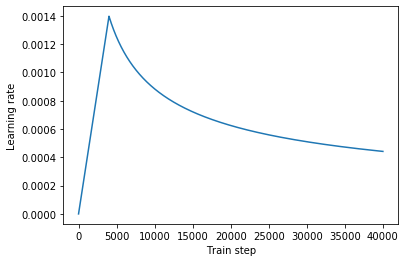

In [29]:
temp_learning_rate_schedule = CustomizedSchedule(d_model)

plt.plot(
    temp_learning_rate_schedule(
        tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning rate")
plt.xlabel("Train step")

In [30]:
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction = "none")

def loss_function(real, pred):
    # 凡是有padding的地方mask上对应的值都是0
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

In [35]:
def create_masks(inp, tar):
    """
    Encoder:
        - encoder_padding_mask (self attention of EncoderLayer)
    Decoder:
        - look_ahead_mask (self attention of DecoderLayer)
        - encoder_decoder_padding_mask (en-decoder attention of DecoderLayer)
        - decoder_padding_mask (self attention of DecoderLayer)
    """
    encoder_padding_mask = create_padding_mask(inp)
    encoder_decoder_padding_mask = create_padding_mask(inp)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    decoder_padding_mask = create_padding_mask(tar)
    # 作用在同一层的mask合并（与操作）
    decoder_mask = tf.maximum(decoder_padding_mask,
                             look_ahead_mask)
#     print(encoder_padding_mask.shape)
#     print(encoder_decoder_padding_mask.shape)
#     print(look_ahead_mask.shape)
#     print(decoder_padding_mask.shape)
#     print(decoder_mask.shape)
    return encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask, 

In [32]:
temp_inp, temp_tar = iter(train_dataset.take(1)).next()

In [33]:
print(temp_inp.shape)
print(temp_tar.shape)
create_masks(temp_inp, temp_tar)

(64, 38)
(64, 39)
(64, 1, 1, 38)
(64, 1, 1, 38)
(39, 39)
(64, 1, 1, 39)
(64, 1, 39, 39)


(<tf.Tensor: id=319518, shape=(64, 1, 1, 38), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: id=319550, shape=(64, 1, 39, 39), dtype=float32, numpy=
 array([[[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 1

#### 4.3 train_step

In [40]:
# os.environ["TF_CPP_MIN_LOG_LEVEL"]='3'

train_loss = keras.metrics.Mean(name = "train_loss")
train_accuracy = keras.metrics.SparseCategoricalAccuracy(name = "train_accuracy")

@tf.function
def train_step(inp, tar):
    # 把tar_inp 输入给decoder, 预测target_real是否正确
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask = create_masks(inp, 
                                                                                    tar_inp )
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True,
                                    encoder_padding_mask,
                                    decoder_mask,
                                    encoder_decoder_padding_mask)
        
        loss = loss_function(tar_real, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real, predictions)
    
epochs = 20
for epoch in range(epochs):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        if batch % 200 == 0:
            print("Epoch {} Batch {} Loss {:.4f} Acc {:.4f}".format(
                epoch + 1, batch, train_loss.result(), 
                train_accuracy.result()))
            
    print("Epoch {}  Loss {:.4f} Acc {:.4f}".format(
                epoch + 1, 
        train_loss.result(), 
                train_accuracy.result()))
    print("Time take for 1 epoch: {} secs \n".format(time.time() - start))

Epoch 1 Batch 0 Loss 1.3044 Acc 0.2056
Epoch 1 Batch 200 Loss 1.4826 Acc 0.2179
Epoch 1 Batch 400 Loss 1.4699 Acc 0.2217
Epoch 1 Batch 600 Loss 1.4513 Acc 0.2252
Epoch 1  Loss 1.4388 Acc 0.2270
Time take for 1 epoch: 652.9913294315338 secs 

Epoch 2 Batch 0 Loss 1.1689 Acc 0.2212
Epoch 2 Batch 200 Loss 1.2980 Acc 0.2390
Epoch 2 Batch 400 Loss 1.2821 Acc 0.2434
Epoch 2 Batch 600 Loss 1.2636 Acc 0.2470
Epoch 2  Loss 1.2536 Acc 0.2486
Time take for 1 epoch: 66.16948676109314 secs 

Epoch 3 Batch 0 Loss 0.9997 Acc 0.2459
Epoch 3 Batch 200 Loss 1.1393 Acc 0.2586
Epoch 3 Batch 400 Loss 1.1295 Acc 0.2623
Epoch 3 Batch 600 Loss 1.1162 Acc 0.2653
Epoch 3  Loss 1.1084 Acc 0.2666
Time take for 1 epoch: 65.98498272895813 secs 

Epoch 4 Batch 0 Loss 0.8937 Acc 0.2615
Epoch 4 Batch 200 Loss 1.0228 Acc 0.2733
Epoch 4 Batch 400 Loss 1.0167 Acc 0.2763
Epoch 4 Batch 600 Loss 1.0080 Acc 0.2789
Epoch 4  Loss 1.0026 Acc 0.2800
Time take for 1 epoch: 65.6142749786377 secs 

Epoch 5 Batch 0 Loss 0.8026 Acc 0

### 5. Evaluate

In [54]:
"""\
eg:     A B C D -> E F G
train:  A B C D, E F G ->F G H
eval:   A B C D -> E
        A B C D, E -> F
        A B C D, E F -> G
        A B C D, E F G -> H
"""
def evaluate(inp_sentence):
    input_id_sentence = [pt_tokenizer.vocab_size] \
                        + pt_tokenizer.encode(inp_sentence) \
                        + [pt_tokenizer.vocab_size + 1]
    #encoder_input.shape: (1, input_sentence_length)
    encoder_input = tf.expand_dims(input_id_sentence, 0)
    
    # decoder_input.shape: (1,1)
    decoder_input = tf.expand_dims([en_tokenizer.vocab_size], 0)
    
    for i in range(max_length):
        encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask = create_masks(
            encoder_input, decoder_input)
        
        #  predictions.shape: (batch_size, output_target_len, target_vocab_size)
        predictions, attention_weights = transformer(
            encoder_input,
            decoder_input,
            False,
            encoder_padding_mask,
            decoder_mask,
            encoder_decoder_padding_mask)
        # 当单步输出用
        predictions = predictions[:, -1 ,:]
        predicted_id = tf.cast(tf.argmax(predictions, axis= -1),
                              tf.int32)
        if tf.equal(predicted_id, en_tokenizer.vocab_size +1):
            return tf.squeeze(decoder_input, axis = 0), attention_weights
        
        decoder_input = tf.concat([decoder_input, [predicted_id]], axis = -1)
    return tf.squeeze(decoder_input, axis = 0), attention_weights 

In [77]:
def plot_encoder_decoder_attention(attention, input_sentence,
                                  result, layer_name):
    fig = plt.figure(figsize=(16,8))
    input_id_sentence = pt_tokenizer.encode(input_sentence)
    
    # attention[layer_name].shape: (batch_size = 1, num_heads, tar_len. input_len)
    attention = tf.squeeze(attention[layer_name], axis = 0)
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
        # 做切片， 因为到最后<end>，就直接返回了，attention并未放到矩阵里
        ax.matshow(attention[head][:-1, :])
        fontdict = {"fontsize":10}
        # x轴锚点数目
        ax.set_xticks(range(len(input_id_sentence)+2))
        ax.set_yticks(range(len(result)))
                      
        ax.set_ylim(len(result)-1.5, -0.5)
        ax.set_xticklabels(["<start>"] + [pt_tokenizer.decode([i]) for i in input_id_sentence],
                         fontdict=fontdict, rotation = 90)
        # 排除start end
        ax.set_yticklabels([en_tokenizer.decode([i]) for i in result if i < en_tokenizer.vocab_size],
                         fontdict=fontdict, rotation = 90)
        ax.set_xlabel("Head {}".format(head +1))
    plt.tight_layout()
    plt.show()

In [68]:
def translate(input_sentence, layer_name = ""):
    result, attention_weights = evaluate(input_sentence)
    
    predicted_sentence = en_tokenizer.decode(
            [i for i in result if i < en_tokenizer.vocab_size])
    print("Input : {}".format(input_sentence))
    print("Predicted translation : {}".format(predicted_sentence))
    
    if layer_name:
        plot_encoder_decoder_attention(attention_weights, input_sentence,
                                      result, layer_name)

In [69]:
translate("está muito frio aqui.")

Input : está muito frio aqui.
Predicted translation : it 's very cold here .


In [70]:
translate("esta é a minha vida")

Input : esta é a minha vida
Predicted translation : this is my life .


In [62]:
translate("você fica em casa")

Input : você fica em casa
Predicted translation : you take your home .


In [63]:
translate("você ainda está em casa?")

Input : você ainda está em casa?
Predicted translation : are you still home ?


In [65]:
translate("este é o primeiro livro que eu já li.")

Input : este é o primeiro livro que eu já li.
Predicted translation : this is the first book that i already have less .


### 训练数据量小，次数少

Input : este é o primeiro livro que eu já li.
Predicted translation : this is the first book that i already have less .


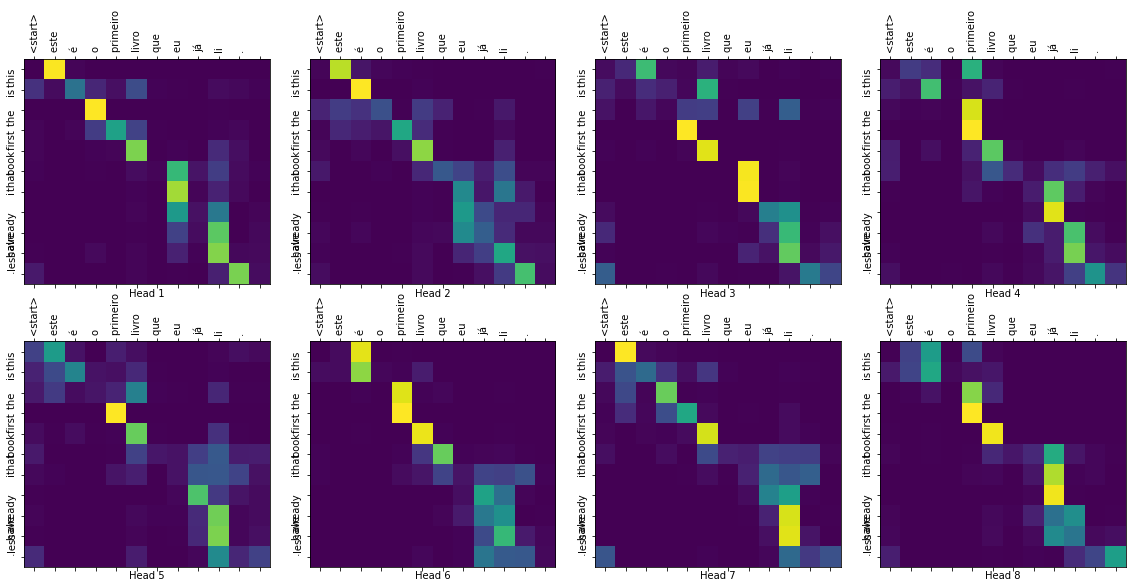

In [78]:
translate("este é o primeiro livro que eu já li.", layer_name = "decoder_layer4_attn_2")

#### 不同头的attention 可以提取到不同特征